In [1]:
# pip install --ignore-installed --no-cache-dir astro-datalab
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord, ICRS, Galactic
from astroquery.xmatch import XMatch
from astroquery.gaia import Gaia
from astropy.table import Table, join,vstack
import healpy as hp
from astropy.io import fits
# %matplotlib inline
# from IPython.core.display import display, HTML

Could not import regions, which is required for some of the functionalities of this module.


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Check Lewis electron density map

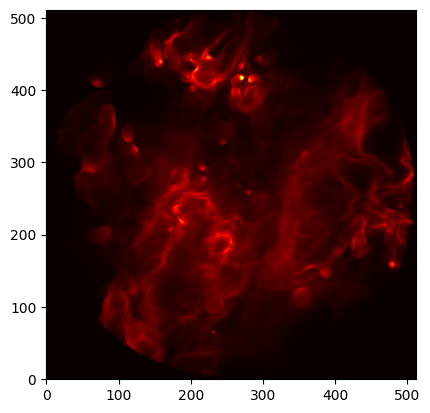

In [208]:
filename = '/Users/anniegao/Documents/CG_mapping_files/ne.hdf5'
with h5py.File(filename, "r") as f:
    density_grid = np.array(f['ne_cgs.hdf5'])
density_grid_transposed = np.transpose(density_grid,axes=(1,0,2))
plt.imshow(np.nansum(density_grid_transposed,axis=2),origin='lower',cmap='hot')

In [209]:
hdu = fits.PrimaryHDU(density_grid)
hdr = hdu.header
hdr['NAXIS'] = 3 #number of array dimensions
hdr['NAXIS1'] = 512
hdr['NAXIS2'] = 512
hdr['NAXIS3'] = 512
hdr['CTYPE1'] = 'Z' 
hdr['CUNIT1'] = 'pc'
hdr['CDELT1'] = 2500/512
hdr['CRVAL1'] = -1250
hdr['CRPIX1'] = 1.0
hdr['CTYPE2'] = 'Y' 
hdr['CUNIT2'] = 'pc'
hdr['CDELT2'] = 2500/512
hdr['CRVAL2'] = -1250
hdr['CRPIX2'] = 1.0
hdr['CTYPE3'] = 'X' 
hdr['CUNIT3'] = 'pc'
hdr['CDELT3'] = 2500/512
hdr['CRVAL3'] = -1250
hdr['CRPIX3'] = 1.0
hdr['CUNIT'] = 'erg s-1 cm-2 arcsec-2'
hdul = fits.HDUList([hdu])
# hdul.writeto('/Users/anniegao/Documents/CG_mapping_files/ne.fits')

In [210]:
f_ne = fits.open('/Users/anniegao/Documents/CG_mapping_files/ne.fits')[0]
f_ne.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  512                                                  
NAXIS2  =                  512                                                  
NAXIS3  =                  512                                                  
EXTEND  =                    T                                                  
CTYPE1  = 'Z       '                                                            
CUNIT1  = 'pc      '                                                            
CDELT1  =            4.8828125                                                  
CRVAL1  =                -1250                                                  
CRPIX1  =                  1.0                                                  
CTYPE2  = 'Y       '        

### Cut the map around the Gum region

In [211]:
gum_ne = density_grid[188: 304, 114:230, 196:312]

In [212]:
hdu = fits.PrimaryHDU(gum_ne)
hdr = f_ne.header
hdr['NAXIS1'] = hdr['NAXIS2'] = hdr['NAXIS3'] = 116
hdr['CRVAL1'] = -1250 + 196*(2500/512)
hdr['CRVAL2'] = -1250 + 114*(2500/512)
hdr['CRVAL3'] = -1250 + 188*(2500/512)
hdu = fits.PrimaryHDU(gum_ne, header=hdr)
hdul = fits.HDUList([hdu])
# hdul.writeto('/Users/anniegao/Documents/CG_mapping_files/ne_Gum.fits')

### Check CGs in the electron map

In [213]:
CG_loc = pd.read_csv('/Users/anniegao/Documents/dustmaps_files/CG_w_tails.csv')

In [214]:
for CG in CG_loc.Name:
    t = Table(names=('x[px]', 'y[px]', 'z[pc]', 'l[deg]', 'b[deg]', 'd[pc]'))
    ra, dec = CG_loc[CG_loc['Name'] == CG]['ra_deg'], CG_loc[CG_loc['Name'] == CG]['dec_deg']
    for dis in range(250, 550, 10):
        coord0 = SkyCoord(SkyCoord(ra=ra, dec=dec, unit=(u.deg, u.deg),frame='icrs').transform_to(Galactic), distance = dis*u.pc)
        l = coord0.l.value[0]
        b = coord0.b.value[0]
        d = coord0.distance.value[0]
        x = coord0.cartesian.x.value[0]
        y =coord0.cartesian.y.value[0]
        z = coord0.cartesian.z.value[0]
        t.add_row([x, y, z, l, b, d])
    # t.write(f'/Users/anniegao/Documents/CG_mapping_files/CG_rays/{CG}_line.fits', overwrite = True)

In [215]:
## Check Yifei map
gum_1 = fits.open('/Users/anniegao/Dropbox/Gum_Nebula/data/gum_dust_map.fits')
Halpha_map = fits.open('/Users/anniegao/Downloads/Halpha.fits')
Halpha_map[0].header = gum_1[0].header
Halpha_map[0].header['NAXIS1'] = 75
Halpha_map[0].header['NAXIS2'] = 75
Halpha_map[0].header['NAXIS3'] = 75
# Halpha_map[0].header['CTYPE1'] = 'Z'
# Halpha_map[0].header['CTYPE3'] = 'X'
Halpha_map[0].header['CDELT1'] = 4.0
Halpha_map[0].header['CDELT2'] = 4.0
Halpha_map[0].header['CDELT3'] = 4.0
Halpha_map[0].header['CRVAL1'] = -180 
Halpha_map[0].header['CRVAL2'] = -480
Halpha_map[0].header['CRVAL3'] = -235
# Halpha_map.writeto('/Users/anniegao/Downloads/Halpha_headerCorrected.fits')

## Query stars

In [216]:
cg_table = pd.read_csv('/Users/anniegao/Documents/dustmaps_files/CG_w_tails.csv')
from astropy.table import Table
t = Table.read("/Users/anniegao/Documents/dustmaps_files/CG30_assoc_stars/CG30_stars.csv",format='csv')
t.colnames
t.remove_column('col0')
# t.write("CG30_Sep23.csv",format='csv')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/anniegao/Documents/dustmaps_files/CG30_assoc_stars/CG30_stars.csv'

In [ ]:
print(qc.schema('decaps_dr2.x1p5__object__gaia_dr3__gaia_source'))


Schema: decaps_dr2
 Table: x1p5__object__gaia_dr3__gaia_source

     Column Name   Description
     -----------   -----------
             id1   ID in left/first table (obj_id)
             ra1   Right ascension in left/first table (ra)
            dec1   Declination in left/first table (dec)
             id2   ID in right/second table (source_id)
             ra2   Right ascension in right/second table (ra)
            dec2   Declination in right/second table (dec)
        distance   Distance between ra1,dec1 and ra2,dec2 (arcsec)



### Check the VVVX map

In [ ]:
vvvx_file = fits.open('/Users/anniegao/Documents/CG_mapping_files/CG31/jhk1017.fits')
vvvx = vvvx_file[1].data #mag_1 = J, mag_2 = H, mag_3 = Ks
vvvx_file[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   64 / length of dimension 1                          
NAXIS2  =               319831 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    8 / number of table fields                         
TTYPE1  = 'ra      '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'dec     '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'mag_1   '        

## Entire CG 30-31 Complex

* Column information: https://datalab.noirlab.edu/query.php?name=decaps_dr2.object

In [ ]:
from astropy.io import fits
from astropy.wcs import WCS
f_CGplot = fits.open('/Users/anniegao/Documents/dustmaps_files/CG30_assoc_stars/CG30cutout_122.3822_-36.0713.fits')
CG_w = WCS(f_CGplot[0].header)

## Meeting Notes:
* Query CG 30-31 region; apply the 'chi square' mask to see the ones that fit well. 
* Look for ~3-4 mag of extinction jump.
* Add VVVX data later if needed
* build pipline
* Two mass column description:
https://irsa.ipac.caltech.edu/data/2MASS/docs/releases/allsky/doc/sec2_2a.html
<!-- * Make the plot in Demo 3 (uses 'dist_vs_red' function. adjust avlim values. ) -->

In [ ]:
# this version uses vizier, but we can use noirlab, as other catalog
# from astroquery.vizier import Vizier
# from astropy.coordinates import Angle
# import astropy.units as u
# import astropy.coordinates as coord
# vizier.ROW_LIMIT = -1
# ll = SkyCoord(ra = 122.46*u.deg, dec=-36.13*u.deg ) #lower left boundary
# print(ll.ra, ll.dec)
# ur = SkyCoord(ra = 122.30*u.deg, dec=-35.82*u.deg ) # upper right boundary
# print(ur.ra, ur.dec)
# vizier = Vizier()
# CG30_2mass = vizier.query_region(coord.SkyCoord(ra=122.38, dec=-35.975,
#                                                 unit=(u.deg, u.deg),frame='icrs'),
#                                                 width='0d9m36s',height = '0d18m36s',
#                                                 catalog = 'II/246/out') #II/241/out, II/246/out
# print(result)

In [ ]:
# To check duplicated rows:
# duplicates = merge_xmatch[merge_xmatch.duplicated(subset='obj_id', keep=False)]
# grouped_duplicates = duplicates.groupby('obj_id')
# for obj_id, group in grouped_duplicates:
#     print(f"Duplicated obj_id: {obj_id}")
#     print(group['angDist'])
#     print("Decide whether to keep the first or second occurrence.\n")

Notes: 

- CG30: \
        RA = (122.3, 122.46), Dec = (-36.13, -35.82)
- CG31: \
        RA = (122, 122.3), Dec = (-36.07, -35.83)
- CG31_back_reddened:  \
        RA = (121.7, 122.38), Dec = (-35.83, -35.6)

In [148]:
from dl import queryClient as qc
ra_bound1, ra_bound2 = 122.3, 122.46 #121.7, 122.38
dec_bound1, dec_bound2 = -36.13, -35.82 #-35.83, -35.6
region_name = "CG30" #"CG31_back_reddened"

In [ ]:
## query data
query1 = f"""
        SELECT *
        FROM decaps_dr2.object
        WHERE (ra<{ra_bound2} AND ra>{ra_bound1} AND dec<{dec_bound2} AND dec>{dec_bound1}) """
query3 = f"""SELECT * 
            FROM twomass.psc
            WHERE (ra<{ra_bound2} AND ra>{ra_bound1} AND dec<{dec_bound2} AND dec>{dec_bound1}) """
df1 = qc.query(sql=query1,fmt='table') # df1.write("/Users/anniegao/Documents/CG_mapping_files/CG31/CG31_decaps2.csv", format='csv')
df3 = qc.query(sql=query3,fmt='table') # df3.write("/Users/anniegao/Documents/CG_mapping_files/CG31/CG31_2mass.csv", format='csv')

## Cross Match with Gaia
from astroquery.xmatch import XMatch
gaia_xmatched = XMatch.query(cat1 = df1, cat2='vizier:I/355/gaiadr3', max_distance= 0.5*u.arcsec, colRA1='ra', colDec1='dec')
df1_pd = df1.to_pandas()
xmatch_pd = gaia_xmatched.to_pandas()
xmatch_pd_tomerge = xmatch_pd.iloc[:, 210:]
xmatch_pd_tomerge['obj_id'] = xmatch_pd['obj_id'].values
xmatch_pd_tomerge['angDist'] = xmatch_pd['angDist'].values
merge_xmatch = df1_pd.merge(xmatch_pd_tomerge, how='left', left_on='obj_id', right_on='obj_id')
merged_pd = merge_xmatch.drop_duplicates(subset='obj_id', keep='first') # because there are 13 stars that are duplicated -- two Gaia sources are within 0.5 arcsec from Decaps2. Only keep the closer one. 
merged_table = Table.from_pandas(merged_pd) # convert back to astropy table # merged_table.write("/Users/anniegao/Documents/CG_mapping_files/CG31/CG31_Decaps2Gaia_crossmatched.csv",format='csv')
print('Finished crossmatching with Gaia')
## Cross Match with 2MASS
twomass_xmatched = XMatch.query(cat1 = df1, cat2 = 'vizier:II/246/out', max_distance= 0.5*u.arcsec, colRA1='ra', colDec1='dec')
twomass_xmatch_pd = twomass_xmatched.to_pandas()
twomass_xmatch_id = twomass_xmatch_pd.iloc[:, 210:211]
twomass_xmatch_id['obj_id'] = twomass_xmatch_pd['obj_id'].values
twomass_xmatch_id['angDist'] = twomass_xmatch_pd['angDist'].values
merge1 = df1_pd.merge(twomass_xmatch_id, how='left', left_on='obj_id', right_on='obj_id')
merge2 = merge1.merge(df3.to_pandas().iloc[:, 2:], how='left',left_on='2MASS', right_on = 'designation') # Table.from_pandas(merge2).write("/Users/anniegao/Documents/CG_mapping_files/CG31/CG31_Decaps2TwoMASS_crossmatched.csv",format='csv', overwrite=True)
print('Finished crossmatching with 2MASS')
## Merge three tables
a = merge2.iloc[:, 209:]
a['obj_id'] = merge2['obj_id']
decaps_2mass_gaia = merged_table.to_pandas().merge(a, on = 'obj_id') # merge Decaps + 2MASS with Decaps + Gaia 
print('Finished crossmatching Decaps2, Gaia, 2MASS; and saved.')
# Table.from_pandas(decaps_2mass_gaia).write(f"/Users/anniegao/Documents/CG_mapping_files/CG31/{region_name}_Decaps2TwoMASS_Gaia_crossmatched.csv",format='csv', overwrite=True)

Finished crossmatching with Gaia
Finished crossmatching with 2MASS
Finished crossmatching Decaps2, Gaia, 2MASS; and saved.


In [ ]:
## confirm the stars are covering the globule and not other background region
# merge CG30, CG31, CG31-backreddened region data
# table1 = pd.read_csv('/Users/anniegao/Documents/CG_mapping_files/CG30/CG30_Decaps2TwoMASS_Gaia_crossmatched.csv')
# table2 = pd.read_csv('/Users/anniegao/Documents/CG_mapping_files/CG31/CG31_Decaps2TwoMASS_Gaia_crossmatched.csv')
# table3 = pd.read_csv('/Users/anniegao/Documents/CG_mapping_files/CG31/CG31_back_reddened_Decaps2TwoMASS_Gaia_crossmatched.csv')
# pd.concat([table1, table2, table3]).to_csv('/Users/anniegao/Documents/CG_mapping_files/CG31/CG30_CG31_CG31back_decaps2MassGaia_crossmatched.csv', index=False)

### Brutus for stellar modeling

In [11]:
import os
import brutus
import h5py
import sys
import glob
from brutus import filters
from brutus import seds
from brutus import utils
from brutus.utils import inv_magnitude
from brutus import fitting
from brutus import pdf
from scipy import stats
from numpy import unravel_index
import signal
import time
from zero_point import zpt
import shutil

In [16]:
## Fit data 
Ndraws = 100 #draws to save to generate the 2D posterior
thin = 20 # factor to thin samples by for saving to disk
filt = filters.decam[1:] + filters.tmass[:] + filters.vista[2:] #+filters.gaia[:]
# zero points
zp_mist = brutus.utils.load_offsets('/Users/anniegao/Documents/CG_mapping_files/star_modeling/offsets_mist_v9.txt',filters=filt)
# import MIST model grid
gridfile = '/Users/anniegao/Documents/CG_mapping_files/star_modeling/grid_mist_v10.h5'
(models_mist, labels_mist, lmask_mist) = brutus.utils.load_models(gridfile, filters=filt)
BF_mist = fitting.BruteForce(models_mist, labels_mist, lmask_mist)
#load tables for parallax zeropoint correction
zpt.load_tables()

DECam_g (0.0%)
DECam_r (-4.0%)
DECam_i (-5.0%)
DECam_z (-4.0%)
DECam_Y (-5.0%)
2MASS_J (-2.0%)
2MASS_H (4.0%)
2MASS_Ks (3.0%)
VISTA_J (-4.0%)
VISTA_H (3.0%)
VISTA_Ks (2.0%)
Reading filter VISTA_Ks           


In [4]:
merged_table_path = '/Users/anniegao/Documents/CG_mapping_files/CG31/CG31_selected.csv'  #f"/Users/anniegao/Documents/CG_mapping_files/CG31/{region_name}_Decaps2TwoMASS_Gaia_crossmatched.csv"
vvvx_Decaps_CG31 = pd.read_csv('/Users/anniegao/Documents/CG_mapping_files/CG31/vvvxDecaps_CG31.txt', sep=',')
vvvx_to_merge = vvvx_Decaps_CG31.iloc[:, :8].rename(columns={"t1_ra": "ra_vvvx", "t1_dec": 'dec_vvvx', 
                                                             "t1_mag_1": "J_vvvx", "t1_er_1": "err_J_vvvx",
                                                             "t1_mag_2": "H_vvvx", "t1_er_2": "err_H_vvvx",
                                                             "t1_mag_3": "Ks_vvvx", "t1_er_3": "err_Ks_vvvx"
                                                            })
vvvx_to_merge['obj_id'] = vvvx_Decaps_CG31['obj_id']
pd_merged = pd.read_csv(merged_table_path).join(vvvx_to_merge.set_index('obj_id'), on='obj_id')  #.merge(vvvx_to_merge, on = 'obj_id')

In [23]:
## distance: 200-600pc. aka 1000/600<plx<1000/200
dist_select = pd_merged[~((pd_merged['Plx']< 1000/600)|(pd_merged['Plx']>1000/200))]
merged_table = Table.from_pandas(pd_merged)

In [ ]:
# mask once: 
merr_max=0.25

flux_decam = np.c_[merged_table['mean_g'].value, merged_table['mean_r'].value, merged_table['mean_i'].value, merged_table['mean_z'].value, merged_table['mean_y'].value]
flux_decam_err = np.c_[merged_table['err_g'].value, merged_table['err_r'].value, merged_table['err_i'].value,merged_table['err_z'].value, merged_table['err_y'].value]
mag_2mass =  np.c_[merged_table['j_m'].value, merged_table['h_m'].value, merged_table['k_m'].value ] #merged_table['Gmag'], merged_table['BPmag'], merged_table['RPmag'],
magerr_2mass = np.c_[merged_table['j_msigcom'].value, merged_table['h_msigcom'].value, merged_table['k_msigcom'].value]  #merged_table['e_Gmag'], merged_table['e_BPmag'], merged_table['e_RPmag'],
mag_vvvx = np.c_[merged_table['J_vvvx'].value, merged_table['H_vvvx'].value, merged_table['Ks_vvvx'].value ]
magerr_vvvx = np.c_[merged_table['err_J_vvvx'].value, merged_table['err_H_vvvx'].value, merged_table['err_Ks_vvvx'].value ]
mag_decam = -2.5*np.log10(flux_decam)
magerr_decam = 1.086*flux_decam_err/flux_decam
# stack magnitudes and error
mag = np.c_[mag_decam[:], mag_2mass[:], mag_vvvx[:]]
mag_err = np.c_[magerr_decam[:], magerr_2mass[:], magerr_vvvx[:]]
#add 0.02 mag uncertainty in quadrature to decaps
mag_err[:,0:5] = np.sqrt(mag_err[:,0:5]**2 + 0.02**2)
#add 0.03 mag uncertainty in quadrature to vvv/2mass
mag_err[:,5:] = np.sqrt(mag_err[:,5:]**2 + 0.03**2)
# change the magnitude from infinity
mag = np.where(np.isinf(mag), np.nan, mag)
mag_err = np.where(mag_err>merr_max, np.nan, mag_err)
# convert to flux
flux, flux_err = inv_magnitude(mag, mag_err)

#unified quality mask
cc_flag_ok = (merged_table['cc_flg']=='000')
gal_contam_ok = (merged_table['gal_contam'] ==0)

decam_nmag_cflux_ok = np.c_[merged_table['nmag_cflux_ok_g'], merged_table['nmag_cflux_ok_r'], 
                           merged_table['nmag_cflux_ok_i'],merged_table['nmag_cflux_ok_z'],
                           merged_table['nmag_cflux_ok_y']]
decam_fracflux_avg_ok = np.c_[merged_table['fracflux_avg_g'], merged_table['fracflux_avg_r'],
                              merged_table['fracflux_avg_i'], merged_table['fracflux_avg_z'],
                              merged_table['fracflux_avg_y']]
valid_decam = (mag[:, :5]>0) & (decam_nmag_cflux_ok>0) & (decam_fracflux_avg_ok>0.75)
# np.isfinite(mag[:, :5]) & np.isfinite(mag_err[:, :5]) & (mag_err[:, :5]<merr_max)
valid_2mass =(mag[:, 5:8]>0) & (cc_flag_ok[:, None]) & (gal_contam_ok[:, None])
valid_vvvx = (mag[:, 8:]>0) & (mag_err[:, 8:]>0)
clean = np.isfinite(flux) & np.isfinite(flux_err) & (flux_err > 0.)
clean[:, :5] *= valid_decam
clean[:, 5:8] *= valid_2mass
clean[:, 8:] *= valid_vvvx
# threshold on number of good bands
final_mask = (np.sum(clean, axis=1) >= 4) & (np.sum(clean[:, :5], axis=1) >= 1)
merged_table_selected = merged_table[final_mask]
parallax, parallax_err = merged_table_selected['Plx'], merged_table_selected['e_Plx']
correct_parallax_mask = (np.isfinite(parallax)) & (np.isin(merged_table_selected['Solved'], [31, 95]))
from zero_point import zpt
#apply parallax correction
parallax_correction = zpt.get_zpt(merged_table_selected['Gmag'][correct_parallax_mask], 
                                  merged_table_selected['nueff'][correct_parallax_mask], 
                                  merged_table_selected['pscol'][correct_parallax_mask], 
                                  merged_table_selected['elat'][correct_parallax_mask], 
                                  merged_table_selected['Solved'][correct_parallax_mask],
                                  _warnings=False)
parallax_correction[~np.isfinite(parallax_correction)] = 0 
parallax[correct_parallax_mask] = parallax[correct_parallax_mask]-parallax_correction
# psel = np.isclose(parallax_err, 0.) | np.isclose(parallax, 0.) | (parallax_err > 1e6)
# parallax[psel], parallax_err[psel] = np.nan, np.nan
coords = SkyCoord(ra = merged_table_selected['ra'].value*u.deg, dec = merged_table_selected['dec'].value*u.deg ).transform_to('galactic')
mask_1 = np.isfinite(mag_err)
filename = '/Users/anniegao/Documents/CG_mapping_files/star_modeling/output/'
region_data = f'CG31_mist_from_decapsTwomassGaiaVVVX_trial1'
BF_mist.fit(flux[final_mask][::7], flux_err[final_mask][::7], np.tile(final_mask[:, np.newaxis], (1, 11))[final_mask][::7],  #[::30]
            merged_table['SolID'][final_mask][::7], 
            filename+region_data,
            data_coords = np.c_[coords.l.value, coords.b.value][::7], 
            parallax=parallax[::7], 
            parallax_err=parallax_err[::7],
            phot_offsets = zp_mist, 
            # dustfile = dustfile, 
            Ndraws = 250, 
            Nmc_prior = 50, 
            logl_dim_prior=True,
            save_dar_draws = True, 
            running_io = True, 
            verbose= True
            )

In [9]:
# flux[final_mask].shape, flux_err[final_mask].shape, np.tile(final_mask[:, np.newaxis], (1, 11))[final_mask].shape, merged_table['SolID'][final_mask].shape, coords.shape, parallax.shape

(1082, 750, 300)

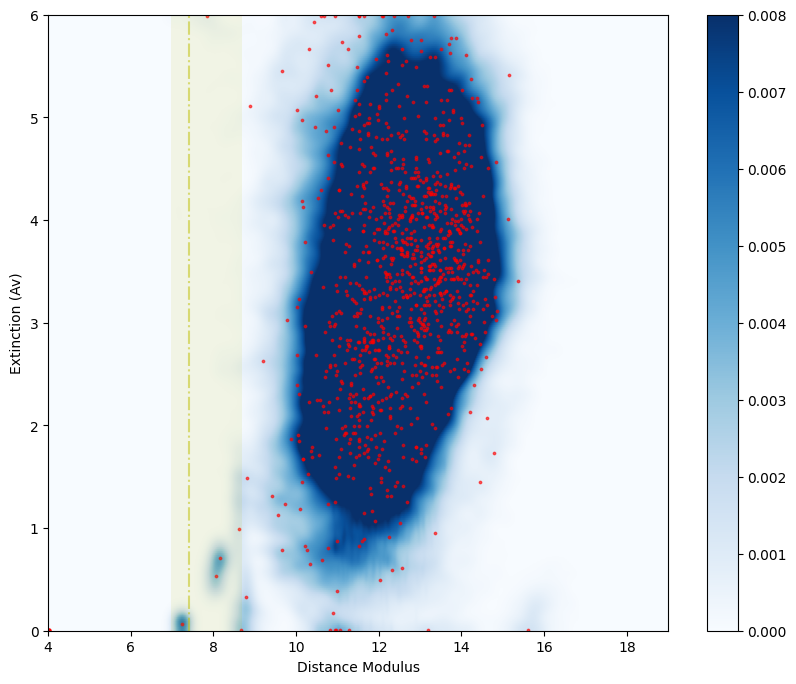

In [7]:
f = h5py.File(filename+region_data+'.h5', 'r')
idxs_mist = f['model_idx']  #model indices
chi2_mist =f['obj_chi2min'] #best fit chi2
nbands_mist = f['obj_Nbands']# number of bands in fit
dists_mist = f['samps_dist'] # distance samples
reds_mist = f['samps_red'] # A(V) samples
dreds_mist = f['samps_dred']# R(V) samples
lnps_mist = f['samps_logp']# log-posterior of samples
good=(stats.chi2.sf(chi2_mist, nbands_mist) > 0.01)
pval = stats.chi2.sf(chi2_mist, nbands_mist)
dists_mist = np.array(dists_mist)
reds_mist = np.array(reds_mist)
dreds_mist = np.array(dreds_mist)
import warnings
warnings.filterwarnings("ignore")
pdfbin, xedges, yedges = brutus.pdf.bin_pdfs_distred((dists_mist, reds_mist, dreds_mist), 
                                                     parallaxes = parallax.value,  # limits smoothing
                                                     parallax_errors=parallax_err.value,  # if parallax SNR is high
                                                    #  avlim=(0., 4.5),
                                                     )
pdfbin = pdfbin[good, :, :]
# plt.imshow(pdfbin[0,:,:])
fig, ax = plt.subplots(figsize=(10, 8))# Prepare the plot
# Set axis labels
ax.set_xlabel('Distance Modulus')
ax.set_ylabel('Extinction (Av)')

# find the location of max likelihood for each star. 
# Step 1: Compute the indices of the maxima
N_stars = pdfbin.shape[0]
max_positions = np.argmax(pdfbin.reshape(N_stars, -1), axis=1)
x_idx, y_idx = np.unravel_index(max_positions, (750, 300))  # shape: (N_stars,)

# Step 2: Convert bin indices to physical coordinates (use center of bins)
x_centers = 0.5 * (xedges[:-1] + xedges[1:])  # shape: (750,)
y_centers = 0.5 * (yedges[:-1] + yedges[1:])  # shape: (300,)

x_max = x_centers[x_idx]
y_max = y_centers[y_idx]

plt.scatter(x_max, y_max, color='red', s=3, alpha=0.6, label='Star max PDF location')

#  sum: collapses the first dimension — aggregating multiple PDFs
plt.imshow(np.sum(pdfbin, axis=0).T, aspect='auto', cmap='Blues', interpolation=None, origin='lower', 
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
            vmin=0, vmax=0.008
            )
# plt.xlim(4, 10)
plt.axvline(7.4, c='y', alpha=0.5, ls='-.')
plt.axvspan(6.98, 8.7, facecolor='y', alpha=0.1)
plt.colorbar()
plt.show()

### M Dwarfs

In [22]:
len(merged_table)

17277

In [28]:
Ag, Ar, Ai = 3.384, 2.483, 1.838
mDwarf1 = merged_table['mean_mag_g']- (Ag/(Ag-Ar))* (merged_table['mean_mag_g'] - merged_table['mean_mag_r']-1.2)
mDwarf2 = merged_table['mean_mag_r'] - merged_table['mean_mag_i'] - (Ar-Ai)/(Ag-Ar) *(merged_table['mean_mag_g']-merged_table['mean_mag_r']-1.2)
id_1 = merged_table[(mDwarf1<20) & (mDwarf2>0.78)]['obj_id'].value
id_2 = pd.read_csv('/Users/anniegao/Documents/CG_mapping_files/CG31/stars_in_CG31_reverse-derived.csv')['obj_id'].values
print(set(id_1) & set(id_2))
m_dwarf_table = merged_table[(mDwarf1<20) & (mDwarf2>0.78)]

{3258706174127863586, 3258706174124428610, 3240691775615043939, 3240709367801088260, 3258706174124429411, 3240691775614992999, 3240709367801087250, 3258706174124427004}


In [38]:
# m_dwarf_table.write('/Users/anniegao/Documents/CG_mapping_files/CG31/decaps2MASS_Gaia_vvvx_MDwarf.csv',  format='csv', overwrite=True)
id_2 = pd.read_csv('/Users/anniegao/Documents/CG_mapping_files/CG31/decaps2MASS_Gaia_MDwarf.csv')['obj_id'].values
id_3 = pd.read_csv('/Users/anniegao/Documents/CG_mapping_files/CG31/decaps2_Gaia_vvvx_MDwarf.csv')['obj_id'].values

print(len(set(id_1) & set(id_2)), len(set(id_1) & set(id_3)))

59 59


In [31]:
flux_decam = np.c_[m_dwarf_table['mean_g'].value, m_dwarf_table['mean_r'].value, m_dwarf_table['mean_i'].value, m_dwarf_table['mean_z'].value, m_dwarf_table['mean_y'].value]
flux_decam_err = np.c_[m_dwarf_table['err_g'].value, m_dwarf_table['err_r'].value, m_dwarf_table['err_i'].value,m_dwarf_table['err_z'].value, m_dwarf_table['err_y'].value]
mag_2mass =  np.c_[m_dwarf_table['j_m'].value, m_dwarf_table['h_m'].value, m_dwarf_table['k_m'].value ] #merged_table['Gmag'], merged_table['BPmag'], merged_table['RPmag'],
magerr_2mass = np.c_[m_dwarf_table['j_msigcom'].value, m_dwarf_table['h_msigcom'].value, m_dwarf_table['k_msigcom'].value]  #merged_table['e_Gmag'], merged_table['e_BPmag'], merged_table['e_RPmag'],
mag_vvvx = np.c_[m_dwarf_table['J_vvvx'].value, m_dwarf_table['H_vvvx'].value, m_dwarf_table['Ks_vvvx'].value ]
magerr_vvvx = np.c_[m_dwarf_table['err_J_vvvx'].value, m_dwarf_table['err_H_vvvx'].value, m_dwarf_table['err_Ks_vvvx'].value ]
mag_decam = -2.5*np.log10(flux_decam)
magerr_decam = 1.086*flux_decam_err/flux_decam
mag = np.c_[mag_decam[:], mag_2mass[:], mag_vvvx[:]]
mag_err = np.c_[magerr_decam[:], magerr_2mass[:], magerr_vvvx[:]]

#add 0.02 mag uncertainty in quadrature to decaps
mag_err[:,0:5] = np.sqrt(mag_err[:,0:5]**2 + 0.02**2)
#add 0.03 mag uncertainty in quadrature to vvv/2mass
mag_err[:,5:] = np.sqrt(mag_err[:,5:]**2 + 0.03**2)
# mag=0 means that there is no detection
mag = np.where(np.isclose(mag, 0.), np.nan, mag)
mag_err = np.where(np.isclose(mag, 0.), np.nan, mag_err)

# convert back to flux
flux, flux_err = inv_magnitude(mag, mag_err)
flux_not_close0 = ~np.isclose(flux, 0.)
flux_mask = (np.sum(flux_not_close0, axis=1)>=4) 


flux_new = flux[flux_mask, :]
flux_err_new = flux_err[flux_mask, :]
mask = np.isfinite(mag_err)[flux_mask, :]  # create boolean band mask
parallax, parallax_err = m_dwarf_table['Plx'][flux_mask], m_dwarf_table['e_Plx'][flux_mask]
correct_parallax_mask = (np.isfinite(parallax)) & (np.isin(m_dwarf_table['Solved'][flux_mask], [31, 95]))
from zero_point import zpt
#apply parallax correction
parallax_correction = zpt.get_zpt(m_dwarf_table['Gmag'][flux_mask][correct_parallax_mask], 
                                  m_dwarf_table['nueff'][flux_mask][correct_parallax_mask], 
                                  m_dwarf_table['pscol'][flux_mask][correct_parallax_mask], 
                                  m_dwarf_table['elat'][flux_mask][correct_parallax_mask], 
                                  m_dwarf_table['Solved'][flux_mask][correct_parallax_mask],
                                  _warnings=False)
parallax_correction[~np.isfinite(parallax_correction)] = 0 
parallax[correct_parallax_mask] = parallax[correct_parallax_mask]-parallax_correction

# psel = np.isclose(parallax_err, 0.) | np.isclose(parallax, 0.) | (parallax_err > 1e6)
# parallax[psel], parallax_err[psel] = np.nan, np.nan
coords = SkyCoord(ra = m_dwarf_table['ra'].value*u.deg, dec = m_dwarf_table['dec'].value*u.deg ).transform_to('galactic')
coords = coords[flux_mask]

filename = '/Users/anniegao/Documents/CG_mapping_files/star_modeling/output/'
region_data = f'CG31_mist_from_decapsTwomassGaiaVVVX_Mdwarf'
BF_mist.fit(flux_new, flux_err_new, mask, 
            merged_table_selected['SolID'], 
            filename+region_data,
            data_coords = np.c_[coords.l.value, coords.b.value], 
            parallax=parallax, 
            parallax_err=parallax_err,
            phot_offsets = zp_mist, 
            # dustfile = dustfile, 
            Ndraws = 250, 
            Nmc_prior = 50, 
            logl_dim_prior=True,
            save_dar_draws = True, 
            running_io = True, 
            verbose= True
            )


Fitting object 59/59 [chi2/n: 15.5/12] (mean time: 0.471 s/obj, est. time remaining:      0.000 s)    


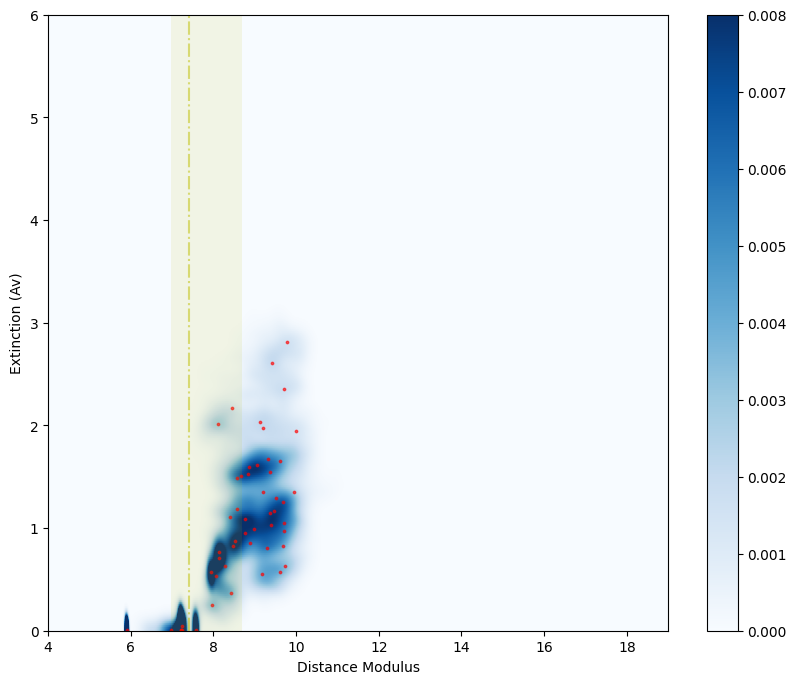

In [32]:
f = h5py.File(filename+region_data+'.h5', 'r')
idxs_mist = f['model_idx']  #model indices
chi2_mist =f['obj_chi2min'] #best fit chi2
nbands_mist = f['obj_Nbands']# number of bands in fit
dists_mist = f['samps_dist'] # distance samples
reds_mist = f['samps_red'] # A(V) samples
dreds_mist = f['samps_dred']# R(V) samples
lnps_mist = f['samps_logp']# log-posterior of samples
good=(stats.chi2.sf(chi2_mist, nbands_mist) > 0.01)
pval = stats.chi2.sf(chi2_mist, nbands_mist)
dists_mist = np.array(dists_mist)
reds_mist = np.array(reds_mist)
dreds_mist = np.array(dreds_mist)
pdfbin, xedges, yedges = brutus.pdf.bin_pdfs_distred((dists_mist, reds_mist, dreds_mist), 
                                                     parallaxes = parallax.value,  # limits smoothing
                                                     parallax_errors=parallax_err.value,  # if parallax SNR is high
                                                    #  avlim=(0., 4.5),
                                                     )
pdfbin = pdfbin[good, :, :]
fig, ax = plt.subplots(figsize=(10, 8))# Prepare the plot
# Set axis labels
ax.set_xlabel('Distance Modulus')
ax.set_ylabel('Extinction (Av)')

# find the location of max likelihood for each star. 
# Step 1: Compute the indices of the maxima
N_stars = pdfbin.shape[0]
max_positions = np.argmax(pdfbin.reshape(N_stars, -1), axis=1)
x_idx, y_idx = np.unravel_index(max_positions, (750, 300))  # shape: (N_stars,)

# Step 2: Convert bin indices to physical coordinates (use center of bins)
x_centers = 0.5 * (xedges[:-1] + xedges[1:])  # shape: (750,)
y_centers = 0.5 * (yedges[:-1] + yedges[1:])  # shape: (300,)

x_max = x_centers[x_idx]
y_max = y_centers[y_idx]

plt.scatter(x_max, y_max, color='red', s=3, alpha=0.6, label='Star max PDF location')

#  sum: collapses the first dimension — aggregating multiple PDFs
plt.imshow(np.sum(pdfbin, axis=0).T, aspect='auto', cmap='Blues', interpolation=None, origin='lower', 
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
            vmin=0, vmax=0.008
            )
# plt.xlim(4, 10)
plt.axvline(7.4, c='y', alpha=0.5, ls='-.')
plt.axvspan(6.98, 8.7, facecolor='y', alpha=0.1)
plt.colorbar()
plt.show()

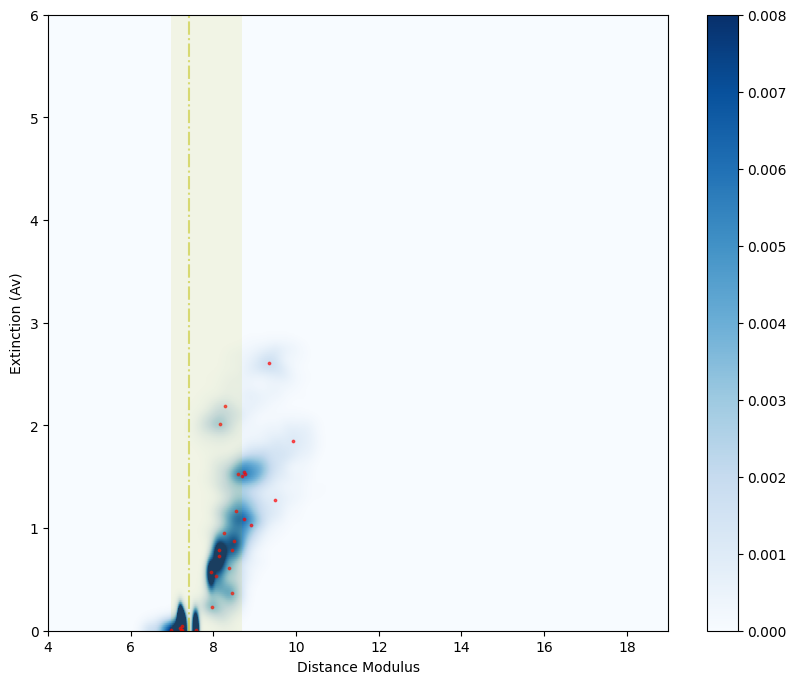

In [20]:
f = h5py.File(filename+region_data+'.h5', 'r')
idxs_mist = f['model_idx']  #model indices
chi2_mist =f['obj_chi2min'] #best fit chi2
nbands_mist = f['obj_Nbands']# number of bands in fit
dists_mist = f['samps_dist'] # distance samples
reds_mist = f['samps_red'] # A(V) samples
dreds_mist = f['samps_dred']# R(V) samples
lnps_mist = f['samps_logp']# log-posterior of samples
good=(stats.chi2.sf(chi2_mist, nbands_mist) > 0.01)
pval = stats.chi2.sf(chi2_mist, nbands_mist)
dists_mist = np.array(dists_mist)
reds_mist = np.array(reds_mist)
dreds_mist = np.array(dreds_mist)
pdfbin, xedges, yedges = brutus.pdf.bin_pdfs_distred((dists_mist, reds_mist, dreds_mist), 
                                                     parallaxes = parallax.value,  # limits smoothing
                                                     parallax_errors=parallax_err.value,  # if parallax SNR is high
                                                    #  avlim=(0., 4.5),
                                                     )
pdfbin = pdfbin[good, :, :]
fig, ax = plt.subplots(figsize=(10, 8))# Prepare the plot
# Set axis labels
ax.set_xlabel('Distance Modulus')
ax.set_ylabel('Extinction (Av)')

# find the location of max likelihood for each star. 
# Step 1: Compute the indices of the maxima
N_stars = pdfbin.shape[0]
max_positions = np.argmax(pdfbin.reshape(N_stars, -1), axis=1)
x_idx, y_idx = np.unravel_index(max_positions, (750, 300))  # shape: (N_stars,)

# Step 2: Convert bin indices to physical coordinates (use center of bins)
x_centers = 0.5 * (xedges[:-1] + xedges[1:])  # shape: (750,)
y_centers = 0.5 * (yedges[:-1] + yedges[1:])  # shape: (300,)

x_max = x_centers[x_idx]
y_max = y_centers[y_idx]

plt.scatter(x_max, y_max, color='red', s=3, alpha=0.6, label='Star max PDF location')

#  sum: collapses the first dimension — aggregating multiple PDFs
plt.imshow(np.sum(pdfbin, axis=0).T, aspect='auto', cmap='Blues', interpolation=None, origin='lower', 
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
            vmin=0, vmax=0.008
            )
# plt.xlim(4, 10)
plt.axvline(7.4, c='y', alpha=0.5, ls='-.')
plt.axvspan(6.98, 8.7, facecolor='y', alpha=0.1)
plt.colorbar()
plt.show()

### First/Old Selection Masks

In [ ]:
## post-process the data, quality cut
band_check = np.c_[(merged_table['nmag_cflux_ok_g']>0) & (merged_table['mean_mag_g']< np.inf) & (merged_table['fracflux_avg_g']>0.75),
                   (merged_table['nmag_cflux_ok_r']>0) & (merged_table['mean_mag_r']< np.inf) & (merged_table['fracflux_avg_r']>0.75),
                   (merged_table['nmag_cflux_ok_i']>0) & (merged_table['mean_mag_i']< np.inf) & (merged_table['fracflux_avg_i']>0.75),
                   (merged_table['nmag_cflux_ok_z']>0) & (merged_table['mean_mag_z']< np.inf) & (merged_table['fracflux_avg_z']>0.75), 
                   (merged_table['nmag_cflux_ok_y']>0) & (merged_table['mean_mag_y']< np.inf) & (merged_table['fracflux_avg_y']>0.75), 
                   (merged_table['j_m']>0) & (merged_table['cc_flg'] =='000') & (merged_table['gal_contam'] ==0), 
                   (merged_table['h_m']>0) & (merged_table['cc_flg']=='000') & (merged_table['gal_contam'] ==0), 
                   (merged_table['k_m']>0) & (merged_table['cc_flg']=='000') & (merged_table['gal_contam'] ==0),
                   (merged_table['J_vvvx']>0) & (merged_table['err_J_vvvx']>0) , 
                   (merged_table['H_vvvx']>0) & (merged_table['err_H_vvvx']>0) , 
                   (merged_table['Ks_vvvx']>0) & (merged_table['err_Ks_vvvx']>0) , 
                   ]
band_mask = (np.sum(band_check, axis=1)>=4 ) & (np.sum(band_check[:, :5], axis=1)>=1)
merged_table_selected = merged_table[band_mask]

flux_decam = np.c_[merged_table_selected['mean_g'].value, merged_table_selected['mean_r'].value, merged_table_selected['mean_i'].value, merged_table_selected['mean_z'].value, merged_table_selected['mean_y'].value]
flux_decam_err = np.c_[merged_table_selected['err_g'].value, merged_table_selected['err_r'].value, merged_table_selected['err_i'].value,merged_table_selected['err_z'].value, merged_table_selected['err_y'].value]
mag_2mass =  np.c_[merged_table_selected['j_m'].value, merged_table_selected['h_m'].value, merged_table_selected['k_m'].value ] #merged_table['Gmag'], merged_table['BPmag'], merged_table['RPmag'],
magerr_2mass = np.c_[merged_table_selected['j_msigcom'].value, merged_table_selected['h_msigcom'].value, merged_table_selected['k_msigcom'].value]  #merged_table['e_Gmag'], merged_table['e_BPmag'], merged_table['e_RPmag'],
mag_vvvx = np.c_[merged_table_selected['J_vvvx'].value, merged_table_selected['H_vvvx'].value, merged_table_selected['Ks_vvvx'].value ]
magerr_vvvx = np.c_[merged_table_selected['err_J_vvvx'].value, merged_table_selected['err_H_vvvx'].value, merged_table_selected['err_Ks_vvvx'].value ]
#mag, mag_err = utils.magnitude(flux, flux_err)
mag_decam = -2.5*np.log10(flux_decam)
magerr_decam = 1.086*flux_decam_err/flux_decam
mag = np.c_[mag_decam[:], mag_2mass[:], mag_vvvx[:]]
mag_err = np.c_[magerr_decam[:], magerr_2mass[:], magerr_vvvx[:]]

#add 0.02 mag uncertainty in quadrature to decaps
mag_err[:,0:5] = np.sqrt(mag_err[:,0:5]**2 + 0.02**2)
#add 0.03 mag uncertainty in quadrature to vvv/2mass
mag_err[:,5:] = np.sqrt(mag_err[:,5:]**2 + 0.03**2)

In [ ]:
mag = np.where(np.isinf(mag), np.nan, mag)
mag_err = np.where(mag_err>0.25, np.nan, mag_err)
clean = np.isfinite(mag) & np.isfinite(mag_err) & (mag_err>0.)
flux, flux_err = inv_magnitude(mag, mag_err)
clean_flux = np.isfinite(flux) & np.isfinite(flux_err) & (flux_err>0.)
clean *= clean_flux
mask_tri = (np.sum(clean, axis=1)>=4) & (np.sum(clean[:, :5], axis=1)>=1)

In [98]:
parallax, parallax_err = merged_table_selected['Plx'], merged_table_selected['e_Plx']
correct_parallax_mask = (np.isfinite(parallax)) & (np.isin(merged_table_selected['Solved'], [31, 95]))
from zero_point import zpt
#apply parallax correction
parallax_correction = zpt.get_zpt(merged_table_selected['Gmag'][correct_parallax_mask], 
                                  merged_table_selected['nueff'][correct_parallax_mask], 
                                  merged_table_selected['pscol'][correct_parallax_mask], 
                                  merged_table_selected['elat'][correct_parallax_mask], 
                                  merged_table_selected['Solved'][correct_parallax_mask],
                                  _warnings=False)
parallax_correction[~np.isfinite(parallax_correction)] = 0 
parallax[correct_parallax_mask] = parallax[correct_parallax_mask]-parallax_correction
# psel = np.isclose(parallax_err, 0.) | np.isclose(parallax, 0.) | (parallax_err > 1e6)
# parallax[psel], parallax_err[psel] = np.nan, np.nan
coords = SkyCoord(ra = merged_table_selected['ra'].value*u.deg, dec = merged_table_selected['dec'].value*u.deg ).transform_to('galactic')


In [ ]:
dustfile = '/Users/anniegao/Dropbox/Gum_Nebula/data/gum_dust_map.fits'  # 3-D dust map
filename = '/Users/anniegao/Documents/CG_mapping_files/star_modeling/output/'
region_data = f'CG31_mist_from_decapsTwomassGaiaVVVX'
BF_mist.fit(flux_new[::3], flux_err_new[::3], mask[::3], 
            merged_table_selected['SolID'][::3], 
            filename+region_data,
            data_coords = np.c_[coords.l.value, coords.b.value][::3], 
            parallax=parallax[::3], 
            parallax_err=parallax_err[::3],
            phot_offsets = zp_mist, 
            # dustfile = dustfile, 
            Ndraws = 250, 
            Nmc_prior = 50, 
            logl_dim_prior=True,
            save_dar_draws = True, 
            running_io = True, 
            verbose= True
            )

Fitting object 808/808 [chi2/n: 10.4/8] (mean time: 1.206 s/obj, est. time remaining:      0.000 s)    


### Load Results

The result of stats.chi2.sf(chi2_mist, nbands_mist) is a p-value, defined as: \
$p = P(\chi^2 >= \chi_{mist} |H0)$

$p$ small: reject the model \
$p$ large: the model is a plausible fit

Here $p$ is 1% significance level. \

chi2_mist is not the raw data or the model prediction; it is precomputed chi-squared test statistic. Now we use the stat.chi2.sf to compute the p-value from this statistic.

In [ ]:
f = h5py.File(filename+region_data+'.h5', 'r')
idxs_mist = f['model_idx']  #model indices
chi2_mist =f['obj_chi2min'] #best fit chi2
nbands_mist = f['obj_Nbands']# number of bands in fit
dists_mist = f['samps_dist'] # distance samples
reds_mist = f['samps_red'] # A(V) samples
dreds_mist = f['samps_dred']# R(V) samples
lnps_mist = f['samps_logp']# log-posterior of samples
good=(stats.chi2.sf(chi2_mist, nbands_mist) > 0.01)
pval = stats.chi2.sf(chi2_mist, nbands_mist)
# plt.hist(chi2_mist[good],bins=np.linspace(0,100),alpha=0.5)
# plt.hist(chi2_mist[~good],bins=np.linspace(0,100),alpha=0.5)
dists_mist = np.array(dists_mist)
reds_mist = np.array(reds_mist)
dreds_mist = np.array(dreds_mist)
import warnings
warnings.filterwarnings("ignore")
pdfbin, xedges, yedges = brutus.pdf.bin_pdfs_distred((dists_mist, reds_mist, dreds_mist), 
                                                     parallaxes = parallax.value,  # limits smoothing
                                                     parallax_errors=parallax_err.value,  # if parallax SNR is high
                                                    #  avlim=(0., 4.5),
                                                     )
pdfbin = pdfbin[good, :, :]

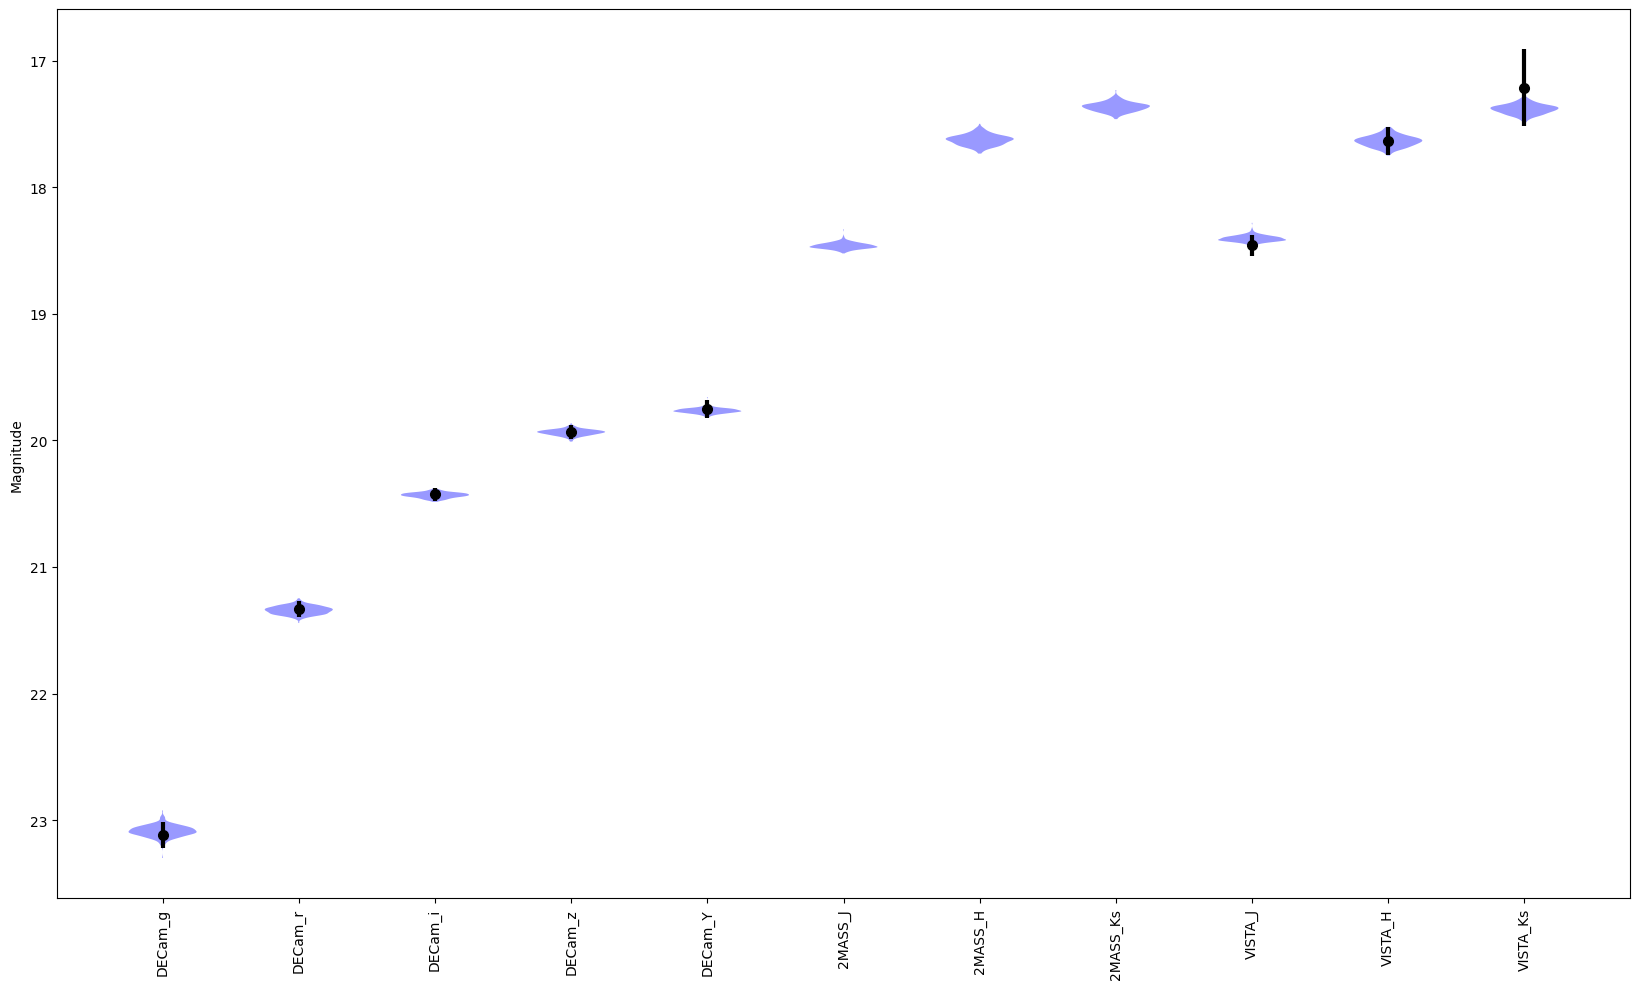

In [100]:
# pick an object
i = 0
from brutus import plotting as bplot
# plot SED (posterior predictive)
fig, ax, parts = bplot.posterior_predictive(models_mist,  # stellar model grid
                                            idxs_mist[i],  # model indices
                                            reds_mist[i],  # A(V) draws
                                            dreds_mist[i],  # R(V) draws
                                            dists_mist[i],  # distance draws
                                            data=flux_new[i], data_err=flux_err_new[i],  # data
                                            # flux = True,
                                            data_mask=mask[i],  # band mask
                                            offset=zp_mist,  # photometric offsets
                                            psig=2.,  # plot 2-sigma errors
                                            labels=filt,  # filters 
                                            vcolor='blue',  # "violin plot" colors for the posteriors
                                            pcolor='black')  # photometry colors for the data

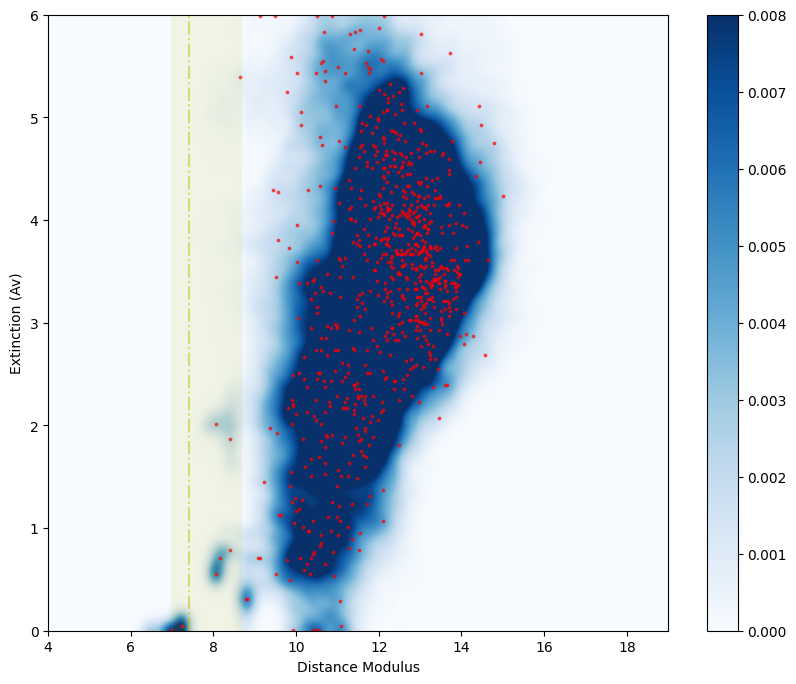

In [ ]:
# plt.imshow(pdfbin[0,:,:])
fig, ax = plt.subplots(figsize=(10, 8))# Prepare the plot
# Set axis labels
ax.set_xlabel('Distance Modulus')
ax.set_ylabel('Extinction (Av)')

# find the location of max likelihood for each star. 
# Step 1: Compute the indices of the maxima
N_stars = pdfbin.shape[0]
max_positions = np.argmax(pdfbin.reshape(N_stars, -1), axis=1)
x_idx, y_idx = np.unravel_index(max_positions, (750, 300))  # shape: (N_stars,)

# Step 2: Convert bin indices to physical coordinates (use center of bins)
x_centers = 0.5 * (xedges[:-1] + xedges[1:])  # shape: (750,)
y_centers = 0.5 * (yedges[:-1] + yedges[1:])  # shape: (300,)

x_max = x_centers[x_idx]
y_max = y_centers[y_idx]

plt.scatter(x_max, y_max, color='red', s=3, alpha=0.6, label='Star max PDF location')

#  sum: collapses the first dimension — aggregating multiple PDFs
plt.imshow(np.sum(pdfbin, axis=0).T, aspect='auto', cmap='Blues', interpolation=None, origin='lower', 
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
            vmin=0, vmax=0.008
            )
# plt.xlim(4, 10)
plt.axvline(7.4, c='y', alpha=0.5, ls='-.')
plt.axvspan(6.98, 8.7, facecolor='y', alpha=0.1)
plt.colorbar()
plt.show()

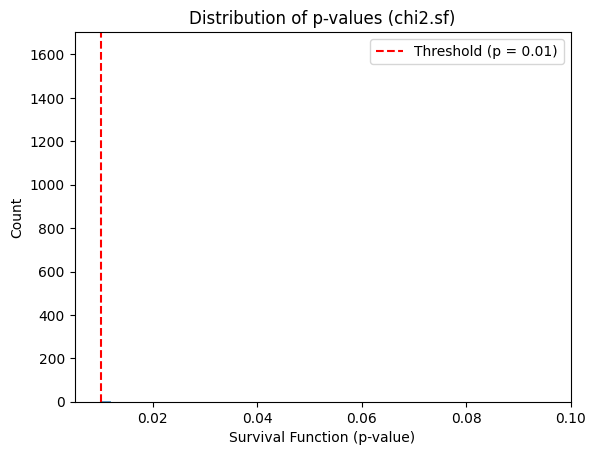

In [34]:
p_values = stats.chi2.sf(chi2_mist, df=nbands_mist)

plt.hist(p_values, bins=500, alpha=0.7)
plt.axvline(0.01, color='red', linestyle='--', label='Threshold (p = 0.01)')
plt.xlabel('Survival Function (p-value)')
plt.ylabel('Count')
plt.title('Distribution of p-values (chi2.sf)')
plt.legend()
plt.xlim(0.005, 0.1)
plt.show()


## Extinction Modeling

Use output stellar posterior samples to model the 3D distribuiton of dust via extinction

In [109]:
from __future__ import print_function, division
from six.moves import range
import sys
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
import h5py
import dynesty
from brutus import los
from brutus.los import LOS_clouds_priortransform as ptform
from brutus.los import LOS_clouds_loglike_samples as loglike


### Deriving Line-of-Sight Extinction Estimates

model the extinction estimates along a given line of sight (LOS) using functions defined in the 'los' module.

In [217]:
# convert from kpc to distance modulus
dms_mist = 5. * np.log10( dists_mist) + 10

In [234]:
nclouds = 1  # number of clouds
ndim = 2 * nclouds + 4  # number of parameters

# adjust default distance modulus limits in ptform
ptform_kwargs = {'dlims': (6., 10.)}

# distances and extinctions to be passed to loglike
logl_args = [dms_mist, reds_mist]
logl_kwargs = {'monotonic': True}  # extinctions must increase

# fit dust along the LOS with dynesty
sampler = dynesty.NestedSampler(loglike, ptform, ndim,
                                ptform_kwargs=ptform_kwargs,
                                logl_args=logl_args,
                                # logl_kwargs=logl_kwargs
                                )